<a href="https://colab.research.google.com/github/linhv0/Finance-Projects/blob/main/Value_at_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Value at Risk
- the potential amount of money that can be lost on a portfolio over a given period of time with a given level of confidence
- involves 3 components:
1. Define holding period - the time frame for risk to be assessed
2. Define level of confidence
3. Calculate the maxium loss

## Practical uses of VaR
- provides management with a clear and quantifiable measure of risk exposure associated with trading and investment operations
- establish limits on the size of positions can be taken on and resouces allocation
- evaluate the performance of trading and investement operations.

## Advantages of VaR
- standardized measure to quantify risk across different assets
- associates potential losses to probability which helps investors understand the likelihood of experiencing losses
- can be applied to all traded assets
- performance assessment

# Three ways to implement VaR for a portfolio
1. Historical Approach
2. Monte Carlo Simulation Approach
3. Covariance Approach


In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm


In [2]:
#set a start date and end date
years = 15
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days = 365*years)

In [3]:
#create a list of tickers
tickers = ['SPY', 'XOM', 'JNJ', 'GOLD', 'VTI']

In [4]:
adj_close_df = pd.DataFrame()

for ticker in tickers:
  data = yf.download(ticker, start=start_date, end=end_date)
  adj_close_df[ticker] = data['Adj Close'] #using adjusted closed prices instead of the normal closed price
                                          #becasue they account for dividends and stock splits. Therefore, it will be more accurate



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
print(adj_close_df)

                   SPY         XOM         JNJ       GOLD         VTI
Date                                                                 
2010-01-04   86.026443   39.594807   41.655678  31.370544   43.747643
2010-01-05   86.254173   39.749413   41.172672  31.758884   43.915573
2010-01-06   86.314919   40.092972   41.507557  32.434605   43.976639
2010-01-07   86.679276   39.967007   41.211304  31.976353   44.159836
2010-01-08   86.967728   39.806675   41.352978  32.178291   44.304882
...                ...         ...         ...        ...         ...
2024-12-20  591.150024  105.870003  144.470001  15.460000  292.339020
2024-12-23  594.690002  106.300003  145.270004  15.590000  294.000000
2024-12-24  601.299988  106.400002  145.850006  15.710000  297.119995
2024-12-26  601.340027  106.489998  145.580002  15.740000  297.290009
2024-12-27  595.010010  106.480003  145.050003  15.680000  294.070007

[3772 rows x 5 columns]


# Calculate the Daily Log Returns and Drop N/As

*Calculate log returns because they are additive overtime and better at handelling compounding.*

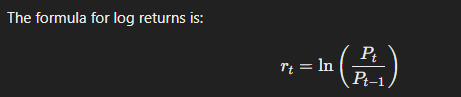

In [6]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1)).dropna()
print(log_returns)

                 SPY       XOM       JNJ      GOLD       VTI
Date                                                        
2010-01-05  0.002644  0.003897 -0.011663  0.012303  0.003831
2010-01-06  0.000704  0.008606  0.008101  0.021053  0.001390
2010-01-07  0.004212 -0.003147 -0.007163 -0.014229  0.004157
2010-01-08  0.003322 -0.004020  0.003432  0.006295  0.003279
2010-01-11  0.001395  0.011157  0.000156  0.005056  0.001377
...              ...       ...       ...       ...       ...
2024-12-20  0.011939  0.003406  0.006179  0.014989  0.011316
2024-12-23  0.005970  0.004053  0.005522  0.008374  0.005666
2024-12-24  0.011054  0.000940  0.003985  0.007668  0.010556
2024-12-26  0.000067  0.000845 -0.001853  0.001908  0.000572
2024-12-27 -0.010582 -0.000094 -0.003647 -0.003819 -0.010890

[3771 rows x 5 columns]


#Create an equally weighted portfolio

In [7]:
portfolio = 500000
weights = np.array([1/len(tickers)] * 5)
print(weights)

[0.2 0.2 0.2 0.2 0.2]


# Calculate the historical portfolio returns

In [8]:
historical_ret = (log_returns * weights).sum(axis=1) #calculate weighted average across 5 securities
print(historical_ret)

Date
2010-01-05    0.002202
2010-01-06    0.007971
2010-01-07   -0.003234
2010-01-08    0.002462
2010-01-11    0.003828
                ...   
2024-12-20    0.009566
2024-12-23    0.005917
2024-12-24    0.006841
2024-12-26    0.000308
2024-12-27   -0.005807
Length: 3771, dtype: float64


In [9]:
days = 5 #holding period - the time frame for risk to be assessed
historical_5_day_ret = historical_ret.rolling(window=days).sum().dropna() #summing up 5 day returns
print(historical_5_day_ret)

Date
2010-01-11    0.013230
2010-01-12    0.000594
2010-01-13   -0.001387
2010-01-14    0.002027
2010-01-15   -0.012126
                ...   
2024-12-20   -0.036699
2024-12-23   -0.019116
2024-12-24   -0.011786
2024-12-26    0.015303
2024-12-27    0.016825
Length: 3767, dtype: float64


# **COVARIANCE APPROACH**
- *assumes the returns of all assets are ***normally distributed***. Keep in mind, this can be a disadvantage of this implemetation as returns often exhibit fat tails, which leads to underestimation of risk.*

## Calculate covariance matrix

In [10]:
cov_matrix = log_returns.cov() * 252
print('Covariance Matrix:')
print(cov_matrix)

Covariance Matrix:
           SPY       XOM       JNJ      GOLD       VTI
SPY   0.029248  0.025769  0.016296  0.011534  0.029864
XOM   0.025769  0.062348  0.015647  0.015644  0.026345
JNJ   0.016296  0.015647  0.027951  0.005390  0.016177
GOLD  0.011534  0.015644  0.005390  0.149833  0.012041
VTI   0.029864  0.026345  0.016177  0.012041  0.030739


## Calculate portfolio standard deviation

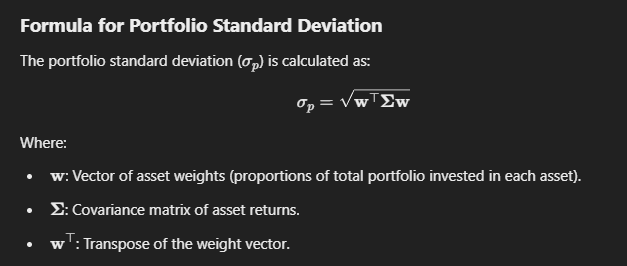

In [11]:
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
portfolio_std= np.sqrt(portfolio_variance)
print(portfolio_std)

0.1611872254925523


In [12]:
#set confidence level
confidence_levels = [0.9, 0.95, 0.99]

## Calculate VaR at different confidence levels
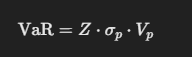

In [13]:
from scipy.stats import norm

VaRs = []

for cl in confidence_levels:
  z_score = norm.ppf(1-cl) #z_score of potential loss
  volatility_5day_period = portfolio_std * np.sqrt(days/252)
  VaR = portfolio * volatility_5day_period *  z_score
  VaRs.append(VaR)


In [14]:
print(VaRs)

[-14548.607971072599, -18672.936174943985, -26409.489975829223]


In [15]:
df = pd.DataFrame({'Confidence Level': confidence_levels,'Value at Risk': VaRs})
df['Value at Risk'] = df['Value at Risk'].apply(lambda x: '${:,.2f}'.format(x))
df['Confidence Level'] = df['Confidence Level'].apply(lambda x: '{:.0%}'.format(x))
print(df)

  Confidence Level Value at Risk
0              90%   $-14,548.61
1              95%   $-18,672.94
2              99%   $-26,409.49


With 99% confidence interval and a portfolio of 500,000 dollars, you would expect to lose no more than 26,409 dollars

In [16]:
# Amount of returns in dollar values
historical_5_day_ret_dollars = historical_5_day_ret * portfolio
print(historical_5_day_ret_dollars)

Date
2010-01-11     6614.798419
2010-01-12      296.768611
2010-01-13     -693.412816
2010-01-14     1013.250657
2010-01-15    -6063.033804
                  ...     
2024-12-20   -18349.297563
2024-12-23    -9558.104627
2024-12-24    -5892.925151
2024-12-26     7651.541955
2024-12-27     8412.395345
Length: 3767, dtype: float64


## Visualizations

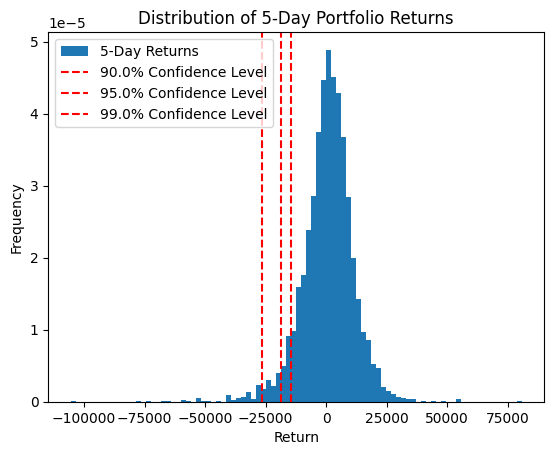

In [17]:

# Plot the histogram
plt.hist(historical_5_day_ret_dollars, bins=90, density=True, label='5-Day Returns')

#Add title and x,y labels
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.title('Distribution of 5-Day Portfolio Returns')

# Add vertical lines representing VaR at each confidence level
for cl, var in zip(confidence_levels, VaRs):
  plt.axvline(x=var, color='r', linestyle='--', label=f'{cl*100}% Confidence Level')
plt.legend()
plt.show()


# **HISTORICAL APPROACH**
*This approach makes no assumption on return distribution. It utilizes historical asset prices to calculate the actual changes in the value of the portfolio over a sample period. It ranks these returns from the lowest to the highest. Then calculate VaR at a specific confidence interval by looking for the return on the (1-confidence interval)th percentile.*

- Advantages: straightforward, no complex stat modelling and no distribution assumption.
- Disadvatages: requires a lot of historical data and is very sensitive to the time period used for estimation.

## Specify confidence interval and calculate VaR

In [18]:
confidence_interval = [0.9, 0.95, 0.99]

for cl in confidence_interval:
  alpha = 1 - cl
  VaR = np.percentile(historical_5_day_ret, alpha * 100) * portfolio
  print(f'In a 5-day period at a {cl*100:.0f}% level confidence, the maximum amount of money that will be lost is: {-VaR:,.0f} dollars')

In a 5-day period at a 90% level confidence, the maximum amount of money that will be lost is: 11,519 dollars
In a 5-day period at a 95% level confidence, the maximum amount of money that will be lost is: 16,535 dollars
In a 5-day period at a 99% level confidence, the maximum amount of money that will be lost is: 32,177 dollars
